In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [3]:
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
LABEL = "Good"

In [4]:
name_list = ["CALU18", "ESPC2"]
all_data_list = []
for name in name_list:
    pre = f"/Users/weilu/Research/davinci/{name}/"
    file = pre + "/AWSEM_energy/AWSEM_energy.log"
    columns = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
    a = pd.read_table(file, names=columns)

    rw_file = pre + "/lowTstructure/rwplusScore.short.txt"
    b = pd.read_table(rw_file, names=["Rw"], sep="\s+").reset_index()
    data = pd.concat([a, b], axis=1)
    data["Name"] = name
    all_data_list.append(data)
all_data = pd.concat(all_data_list)

In [5]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_data = raw_test_data.groupby("Name").get_group("T0792")

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone
from sklearn.svm import SVC
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
        ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

p = 0.9
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(train_set, train_y)
n = 5
results_list = []
picked_list = []
for name, data in all_data.groupby("Name"):
    print(name)
    X = num_pipeline.fit_transform(data)
    eval_set = X
    test= voting_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
#     threshold = test[position_of_top_n][-1]
#     predict_y = np.zeros(len(eval_y),)
#     predict_y[position_of_top_n] = 1
    with open("/Users/weilu/Research/data/structure_selector/nov18_{}_results.csv".format(name), "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
    results_list.append(pd.Series(test))
    print(position_of_top_n)
    for ii,i in enumerate(position_of_top_n):
        os.system(f"cp /Users/weilu/Research/davinci/{name}/lowTstructure/lowTstructure{i}.pdb /Users/weilu/Research/data/structure_selector/nov18/{name}/rank_{ii}_{i}.pdb")
#     predict_y = (test > threshold)
#     print(threshold)


CALU18
[1735 1029 1013 1194 1945]
ESPC2
[59 64 90 23 93]


In [8]:
test[position_of_top_n]

array([ 0.46481138,  0.41746202,  0.36644027,  0.31485466,  0.30941576])

In [ ]:
os.system()

In [72]:
a = pd.concat(results_list)
all_data["predict"] = a
all_data.plot( "Rw", "predict" , kind="scatter")

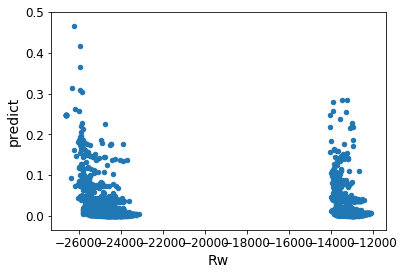